<a href="https://colab.research.google.com/github/201801226/Projects/blob/main/FGSM_PGD_CW_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import urllib.request

import torch
import torch.nn as nn
from torchvision.models import resnet50

In [ ]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode 
model = resnet50(pretrained=True) #pre-trained on imagenet  
model.eval();

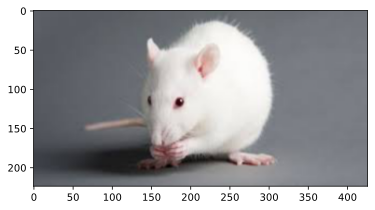

In [ ]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    
#print(imagenet_classes)
true_class=pred.max(dim=1)[1].item()
print(true_class)
print(imagenet_classes[true_class])
print(pred[0,true_class].item())
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,true_class].item())

358
polecat
6.258492469787598
Predicted probability: 0.13599583506584167


In [ ]:
print(nn.CrossEntropyLoss()(pred,torch.LongTensor([true_class])).item())

1.995131015777588


In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(img_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([true_class]))

    opt.zero_grad()
    loss.backward()
    opt.step()  #delta = delta - lr * delta.grad

    if t % 5 == 0:
        print(t, loss.item())
            
    delta.data.clamp_(-epsilon, epsilon)

pred = model(norm(img_tensor + delta))
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,true_class].item())
print(delta)

0 -1.995131015777588
5 -18.07954216003418
10 -22.621431350708008
15 -17.30215072631836
20 -19.381385803222656
25 -17.5408878326416
True class probability: 2.50252552014274e-09
tensor([[[[-0.0078, -0.0078, -0.0078,  ..., -0.0078, -0.0078, -0.0078],
          [-0.0078, -0.0078, -0.0046,  ..., -0.0078, -0.0078, -0.0078],
          [-0.0078, -0.0078,  0.0072,  ...,  0.0078, -0.0078, -0.0029],
          ...,
          [ 0.0036,  0.0065,  0.0043,  ..., -0.0078,  0.0078,  0.0078],
          [ 0.0078, -0.0003, -0.0037,  ..., -0.0078,  0.0078,  0.0078],
          [ 0.0016,  0.0078,  0.0033,  ...,  0.0078,  0.0078, -0.0078]],

         [[ 0.0038,  0.0078,  0.0078,  ..., -0.0078, -0.0078, -0.0078],
          [ 0.0067,  0.0078,  0.0078,  ..., -0.0078, -0.0078, -0.0078],
          [ 0.0078,  0.0078,  0.0078,  ...,  0.0010, -0.0078, -0.0018],
          ...,
          [ 0.0040,  0.0061,  0.0028,  ..., -0.0078,  0.0078,  0.0078],
          [ 0.0078, -0.0044, -0.0078,  ..., -0.0078,  0.0078,  0.0049],


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


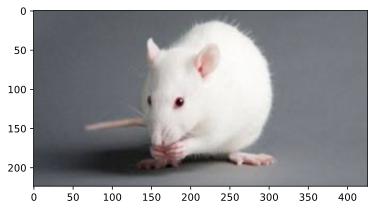

In [ ]:
plt.imshow((img_tensor + delta)[0].detach().numpy().transpose(1,2,0))

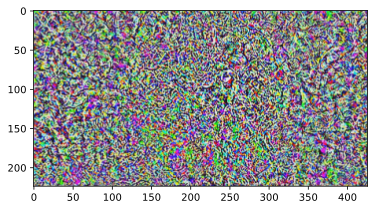

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  piggy_bank
Predicted probability: 0.9991573095321655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: 0.043120644986629486


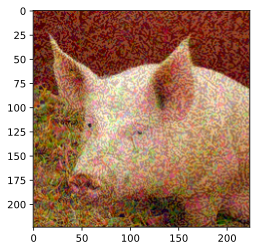

In [ ]:
epsilon=0.12

img_tensor.requires_grad=True

pred1 = model(norm(img_tensor))
loss = -nn.CrossEntropyLoss()(pred1, torch.LongTensor([true_class]))

loss.backward()

adv_img = img_tensor + epsilon*torch.sign(img_tensor.grad)

pred1 = model(norm(adv_img))

print("True class probability:", nn.Softmax(dim=1)(pred1)[0,true_class].item())
plt.imshow((adv_img)[0].detach().numpy().transpose(1,2,0))

In [ ]:
max_class = pred1.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred1)[0,max_class].item())

Predicted class:  West_Highland_white_terrier
Predicted probability: 0.6477439999580383


In [ ]:
# Targeted Attack
delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

targated_class=500
for t in range(100):
    pred = model(norm(img_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([true_class])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([targated_class])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 20.928260803222656
10 -1.429433822631836
20 -12.264627456665039
30 -24.763002395629883
40 -38.30031967163086
50 -46.03642272949219
60 -53.96882247924805
70 -60.8407096862793
80 -69.96150207519531
90 -73.63353729248047


In [ ]:
print(imagenet_classes[targated_class])

cliff_dwelling


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  cliff_dwelling
Predicted probability: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


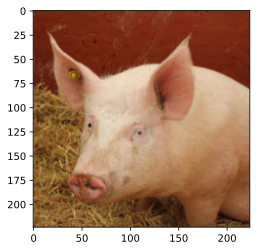

In [ ]:
plt.imshow((img_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


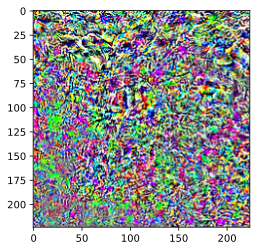

In [ ]:
plt.imshow((50*delta + 0.5)[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


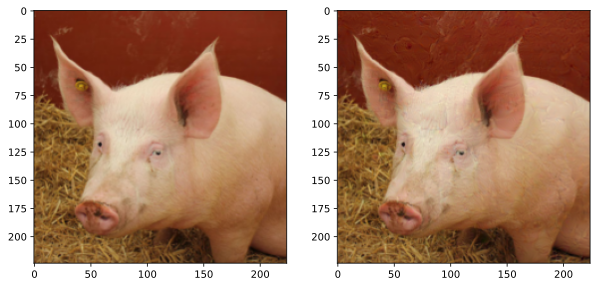

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((img_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((img_tensor + delta)[0].detach().numpy().transpose(1,2,0))